# M2 Data Science – Machine Learning pour la Finance
### Projet : Pricing d'une Option Barrière avec GPR  
**Mimoun Aymane**  
**20201889**

# Rapport de Projet — Pricing d'une Option Barrière avec GPR

Ce rapport présente différentes méthodes numériques pour l’évaluation du prix et des sensibilités (Delta, Gamma) d’une option barrière de type **down-and-out call**.

Les approches explorées sont :

- La méthode de **Monte Carlo Standard**
- L'amélioration par **Brownian Bridge**
- L’estimation via **Gaussian Process Regression (GPR)**


## Sommaire

1. [Importation des packages](#)
2. [Méthodes de pricing Monte Carlo](#)
3. [Calcul des sensibilités (Delta, Gamma)](#)
4. [Génération de datasets pour l’apprentissage](#)
5. [Régression par Processus Gaussiens (GPR)](#)
6. [Visualisation des prédictions](#)
7. [Tableau comparatif des erreurs](#)
8. [Conclusion](#)


## 1. 1. Importation et paramètres

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

In [2]:
K, B, T = 100, 85, 1.0
r, sigma, S0 = 0.05, 0.25, 100
N, M = 10000, 100
epsilon = 1e-6
Z = np.random.randn(N, M)

## 2. Fonctions utilitaires

In [3]:
def down_and_out_call_price(S0, K, B, r, sigma, T):
    """    Calcule la sensibilité Delta de l'option barrière via une approximation par différences centrées.

    Args:
        S0 (float): Prix initial de l'actif sous-jacent.
        K (float): Prix d'exercice de l'option.
        B (float): Niveau de la barrière.
        r (float): Taux d'intérêt sans risque.
        sigma (float): Volatilité de l'actif sous-jacent.
        T (float): Maturité de l'option.
        h (float, optional): Pas utilisé pour l'approximation numérique. Par défaut à 1e-2.

    Returns:
       float: Estimation du Delta de l'option.
    """
    if S0 <= B:
        return 0.0
    mu = (r - 0.5 * sigma**2) / sigma**2
    x1 = np.log(S0 / K) / (sigma * np.sqrt(T)) + (1 + mu) * sigma * np.sqrt(T)
    x2 = np.log(S0 / B) / (sigma * np.sqrt(T)) + (1 + mu) * sigma * np.sqrt(T)
    y1 = np.log(B**2 / (S0 * K)) / (sigma * np.sqrt(T)) + (1 + mu) * sigma * np.sqrt(T)
    y2 = np.log(B / S0) / (sigma * np.sqrt(T)) + (1 + mu) * sigma * np.sqrt(T)
    A = S0 * norm.cdf(x1) - K * np.exp(-r * T) * norm.cdf(x1 - sigma * np.sqrt(T))
    B_term = S0 * (B/S0)**(2*mu) * norm.cdf(y1) - K * np.exp(-r * T) * (B/S0)**(2*mu-2) * norm.cdf(y1 - sigma * np.sqrt(T))
    return A - B_term

def down_and_out_call_delta(S0, K, B, r, sigma, T, h=1e-2):
    """Calcule la sensibilité Gamma de l'option barrière via une approximation par différences finies.

    Args:
       S0 (float): Prix initial de l'actif sous-jacent.
        K (float): Prix d'exercice de l'option.
        B (float): Niveau de la barrière.
        r (float): Taux d'intérêt sans risque.
        sigma (float): Volatilité de l'actif sous-jacent.
        T (float): Maturité de l'option.
        h (float, optional): Pas utilisé pour l'approximation numérique. Par défaut à 1e-2.

    Returns:
        float: Estimation du Gamma de l'option.
    """
    if S0 - h <= B or S0 + h <= B:
        return 0.0  # Si S0+h ou S0-h touche la barrière, delta = 0
    price_plus = down_and_out_call_price(S0 + h, K, B, r, sigma, T)
    price_minus = down_and_out_call_price(S0 - h, K, B, r, sigma, T)
    return (price_plus - price_minus) / (2 * h)


def down_and_out_call_gamma(S0, K, B, r, sigma, T, h=1e-2):
    """Calcule la sensibilité Gamma d'une option down-and-out call par approximation numérique à l'aide de différences finies.

    Args:
        S0 (float): Prix initial de l'actif sous-jacent.
        K (float): Prix d'exercice de l'option (strike).
        B (float): Niveau de la barrière (barrière désactivante).
        r (float): Taux d'intérêt sans risque.
        sigma (float): Volatilité de l'actif sous-jacent.
        T (float): Maturité de l'option (en années).
        h (float, optional): Pas utilisé pour l'approximation. Par défaut à 1e-2.

    Returns:
        float: Estimation du Gamma de l'option. Retourne 0.0 si les prix perturbés touchent la barrière.
    """
    if S0 - h <= B or S0 + h <= B:
        return 0.0
    price_plus = down_and_out_call_price(S0 + h, K, B, r, sigma, T)
    price_0 = down_and_out_call_price(S0, K, B, r, sigma, T)
    price_minus = down_and_out_call_price(S0 - h, K, B, r, sigma, T)
    return (price_plus - 2 * price_0 + price_minus) / (h ** 2)


## 3. Méthodes de pricing Monte Carlo

Nous implémentons ici deux approches classiques pour le pricing d'une option barrière :

- Monte Carlo Standard
- Monte Carlo avec correction Brownian Bridge

In [4]:
def monte_carlo_standard_crn(S0, K, B, r, sigma, T, Z, N, M):
    """ Calcule le prix d'une option down-and-out call en utilisant la méthode de Monte Carlo standard 
    avec nombres aléatoires communs (CRN).

    Args:
       S0 (float): Prix initial de l'actif sous-jacent.
        K (float): Prix d'exercice (strike) de l'option.
        B (float): Niveau de la barrière (barrière désactivante).
        r (float): Taux d'intérêt sans risque.
        sigma (float): Volatilité de l'actif sous-jacent.
        T (float): Maturité de l'option (en années).
        Z (np.ndarray): Matrice (N x M) de variables aléatoires standard normales.
        N (int): Nombre de trajectoires simulées.
        M (int): Nombre de pas de discrétisation par trajectoire.

    Returns:
        tuple: Moyenne du prix estimé de l'option, et erreur standard de l'estimateur.
    """
    dt = T / M
    prices = np.zeros(N)
    for i in range(N):
        S = S0
        barrier_breached = False
        for j in range(M):
            z = Z[i, j]
            S *= np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
            if S <= B:
                barrier_breached = True
        if not barrier_breached:
            prices[i] = np.exp(-r * T) * max(S - K, 0)
    return np.mean(prices), np.std(prices) / np.sqrt(N)


## 3. Calcul des sensibilités (Delta, Gamma)

Nous utilisons la méthode des différences finies, pour estimer les dérivées du prix par rapport à \( S_0 \) :

- **Delta** : sensibilité du prix à une petite variation de \( S_0 \)
- **Gamma** : dérivée seconde (convexité du prix)

In [5]:
def phi_hit(S0, S1, B, sigma, dt):
    """Calcule la probabilité qu'une trajectoire Brownienne atteigne la barrière entre deux dates,
    selon l'approximation du Brownian Bridge.

    Args:
        S0 (float): Valeur du sous-jacent au début de l'intervalle [t_j, t_{j+1}].
        S1 (float): Valeur du sous-jacent à la fin de l'intervalle.
        B (float): Niveau de la barrière.
        sigma (float): Volatilité du sous-jacent.
        dt (float): Pas de temps entre deux dates de monitoring.

    Returns:
        float: Probabilité approchée que la barrière ait été franchie entre les deux instants.
    """
    logB = np.log(B)
    return np.exp(-2 * (np.log(S0) - logB) * (np.log(S1) - logB) / (sigma**2 * dt))

def monte_carlo_bb_crn(S0, K, B, r, sigma, T, Z, N=10000, M=100):
    """Calcule le prix d'une option down-and-out call en utilisant la méthode de Monte Carlo avec correction Brownian Bridge
    et des nombres aléatoires communs (CRN).

    Args:
        S0 (float): Prix initial de l'actif sous-jacent.
        K (float): Prix d'exercice de l'option.
        B (float): Niveau de la barrière (désactivante).
        r (float): Taux d'intérêt sans risque.
        sigma (float): Volatilité de l'actif sous-jacent.
        T (float): Maturité de l'option (en années).
        Z (np.ndarray): Matrice (N x M) de variables normales standard simulées.
        N (int, optional): Nombre de trajectoires simulées. Par défaut à 10 000.
        M (int, optional): Nombre de pas de discrétisation. Par défaut à 100.


    Returns:
        tuple: Moyenne du prix estimé de l'option et erreur standard sur l'estimateur.
    """
    dt = T / M
    prices = np.zeros(N)

    for i in range(N):
        S = np.zeros(M+1)
        S[0] = S0
        log_prod = 0  # utiliser somme des logs pour plus de stabilité

        for j in range(1, M+1):
            z = Z[i, j-1]
            S[j] = S[j-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
            phi = phi_hit(S[j-1], S[j], B, sigma, dt)
            if phi >= 1:
                log_prod = -np.inf  # barrière touchée
                break
            log_prod += np.log(1 - phi)

        prod = np.exp(log_prod) if log_prod > -np.inf else 0.0
        payoff = max(S[-1] - K, 0)
        prices[i] = np.exp(-r * T) * payoff * prod

    return np.mean(prices), np.std(prices) / np.sqrt(N)


In [6]:
def monte_carlo_bb(S0, K, B, r, sigma, T, N=1000, M=100):
    """Calcule le prix d'une option down-and-out call en utilisant la méthode de Monte Carlo 
    avec correction Brownian Bridge (sans réutiliser de variables aléatoires pré-générées).


    Args:
        S0 (float): Prix initial de l'actif sous-jacent.
        K (float): Prix d'exercice (strike) de l'option.
        B (float): Niveau de la barrière désactivante.
        r (float): Taux d'intérêt sans risque.
        sigma (float): Volatilité de l'actif sous-jacent.
        T (float): Maturité de l'option (en années).
        N (int, optional): Nombre de trajectoires simulées. Par défaut à 1000.
        M (int, optional): Nombre de pas de temps (monitoring points). Par défaut à 100.


    Returns:
         tuple: Prix estimé de l'option et erreur standard de l'estimateur.
    """
    dt = T / M
    prices = np.zeros(N)
    for i in range(N):
        S = np.zeros(M+1)
        S[0] = S0
        prod = 1
        for j in range(1, M+1):
            z = np.random.randn()
            S[j] = S[j-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
            prod *= (1 - phi_hit(S[j-1], S[j], B, sigma, dt))
        payoff = max(S[-1] - K, 0)
        prices[i] = np.exp(-r * T) * payoff * prod
    return np.mean(prices), np.std(prices) / np.sqrt(N)

## 4. Génération de datasets pour l'apprentissage

Nous générons des paires (S0, Prix) avec Monte Carlo (Standard ou BB) pour entraîner un modèle de régression.


In [12]:
def generate_dataset_standard(n_samples):
    """Génère un ensemble de données pour l'entraînement de modèles à partir de la méthode 
    de Monte Carlo standard (CRN) pour le pricing d'une option down-and-out call.

    Args:
        n_samples (int): Nombre d'échantillons à générer.

    Returns:
        tuple: 
            - X (np.ndarray): Matrice des variables d'entrée de forme (n_samples, 5) contenant S0, K, B, sigma, r.
            - y (np.ndarray): Vecteur des prix simulés correspondant (taille n_samples).
    """
    X, y = [], []
    for _ in range(n_samples):
        S0 = np.random.uniform(80, 120)
        sigma = np.random.uniform(0.1, 0.5)
        r = np.random.uniform(0.01, 0.1)
        price, _ = monte_carlo_standard_crn(S0, 100, 85, r, sigma, 1, Z, N, M)
        X.append([S0, 100, 85, sigma, r])
        y.append(price)
    return np.array(X), np.array(y)

def generate_dataset_bb(n_samples):
    """Génère un ensemble de données pour l'entraînement de modèles à partir de la méthode 
    de Monte Carlo avec Brownian Bridge pour le pricing d'une option down-and-out call.

    Args:
        n_samples (int): Nombre d'échantillons à générer.
    
    Returns:
        tuple: 
            - X (np.ndarray): Matrice des variables d'entrée de forme (n_samples, 5) contenant S0, K, B, sigma, r.
            - y (np.ndarray): Vecteur des prix simulés correspondant (taille n_samples).
    """
    X, y = [], []
    for _ in range(n_samples):
        S0 = np.random.uniform(80, 120)
        sigma = np.random.uniform(0.1, 0.5)
        r = np.random.uniform(0.01, 0.1)
        price, _ = monte_carlo_bb(S0, 100, 85, r, sigma, 1)
        X.append([S0, 100, 85, sigma, r])
        y.append(price)
    return np.array(X), np.array(y)

## 5. Régression par Processus Gaussiens (GPR)

Nous implémentons un modèle GPR avec noyau RBF.

In [13]:
def rbf_kernel(X1, X2, length_scale=1.0, sigma_f=1.0):
    """Calcule la matrice de covariance à l’aide du noyau RBF (Radial Basis Function).

    Args:
        X1 (np.ndarray): Matrice des points d'entrée de forme (n_samples_1, n_features).
        X2 (np.ndarray): Matrice des points cibles de forme (n_samples_2, n_features).
        length_scale (float, optional): Échelle de longueur du noyau. Plus petite = plus flexible. Par défaut à 1.0.
        sigma_f (float, optional): Écart-type des fonctions sous-jacentes. Par défaut à 1.0.

    Returns:
        np.ndarray: Matrice de covariance de forme (n_samples_1, n_samples_2).
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)

class GaussianProcessRegressor:
    """ Régression par processus gaussien (GPR) avec noyau RBF pour l’approximation de fonctions et l’incertitude prédictive.
    """
    def __init__(self, length_scale=1.0, sigma_f=1.0, noise=1e-6):
        """Initialise le régressseur gaussien.

        Args:
            length_scale (float, optional): Échelle de longueur du noyau RBF. Par défaut à 1.0.
            sigma_f (float, optional): Écart-type du noyau. Par défaut à 1.0.
            noise (float, optional): Bruit d'observation (ajouté sur la diagonale). Par défaut à 1e-6.
        """
        self.length_scale = length_scale
        self.sigma_f = sigma_f
        self.noise = noise
    
    def fit(self, X_train, y_train):
        """Ajuste le GPR sur les données d’entraînement.

        Args:
            X_train (np.ndarray): Données d’entrée d'entraînement, shape (n_samples, n_features).
            y_train (np.ndarray): Cibles correspondantes, shape (n_samples,).
        """
        self.X_train = X_train
        self.y_train = y_train
        self.K = rbf_kernel(X_train, X_train, self.length_scale, self.sigma_f) + self.noise * np.eye(len(X_train))
        self.K_inv = np.linalg.inv(self.K)

    def predict(self, X_test):
        """Effectue une prédiction à partir de nouvelles entrées.

        Args:
            X_test (np.ndarray): Données d’entrée pour la prédiction, shape (n_test_samples, n_features).

        Returns:
              tuple:
                - mu (np.ndarray): Moyenne prédite pour chaque point de test.
                - cov (np.ndarray): Matrice de covariance des prédictions.
        """
        K_s = rbf_kernel(self.X_train, X_test, self.length_scale, self.sigma_f)
        K_ss = rbf_kernel(X_test, X_test, self.length_scale, self.sigma_f) + 1e-8 * np.eye(len(X_test))
        mu = K_s.T.dot(self.K_inv).dot(self.y_train)
        cov = K_ss - K_s.T.dot(self.K_inv).dot(K_s)
        return mu, cov

    def optimize(self):
        """Optimise les hyperparamètres du noyau RBF (length_scale, sigma_f) 
        en maximisant la vraisemblance marginale logarithmique.

        Cette méthode met à jour les valeurs de `length_scale` et `sigma_f` de l'objet.
        """
        def log_marginal_likelihood(params):
            length_scale, sigma_f = params
            if length_scale <= 0 or sigma_f <= 0:
                return np.inf
            K = rbf_kernel(self.X_train, self.X_train, length_scale, sigma_f) + self.noise * np.eye(len(self.X_train))
            try:
                L = np.linalg.cholesky(K)
            except np.linalg.LinAlgError:
                return np.inf
            alpha = np.linalg.solve(L.T, np.linalg.solve(L, self.y_train))
            logdetK = 2 * np.sum(np.log(np.diag(L)))
            lml = -0.5 * np.dot(self.y_train.T, alpha) - 0.5 * logdetK - 0.5 * len(self.X_train) * np.log(2 * np.pi)
            return -lml  # on minimise
        
        res = minimize(
            log_marginal_likelihood,
            x0=[self.length_scale, self.sigma_f],
            bounds=[(1e-5, None), (1e-5, None)],
            method='L-BFGS-B'
        )
        self.length_scale, self.sigma_f = res.x
        print(f"Optimisation terminée : length_scale = {self.length_scale:.4f}, sigma_f = {self.sigma_f:.4f}")


In [14]:
def plot_price_and_delta(S0_values, price_pred, delta_pred, prix_exact=None, delta_exact=None, B=None):
    """Affiche deux courbes : le prix de l'option barrière et son Delta en fonction du prix initial S0.

    Args:
        S0_values (np.ndarray): Vecteur des valeurs de S0 utilisées pour les prédictions.
        price_pred (np.ndarray): Prix prédits de l’option (par GPR ou autre méthode).
        delta_pred (np.ndarray): Valeurs de Delta prédites (par GPR ou autre méthode).
        prix_exact (np.ndarray, optional): Valeurs exactes (ou de référence) du prix pour comparaison. Par défaut None.
        delta_exact (np.ndarray, optional): Valeurs exactes (ou de référence) du Delta pour comparaison. Par défaut None.
        B (float, optional): Niveau de la barrière. Si spécifié, une ligne verticale est tracée sur les graphes.
    """
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # --- Prix ---
    axes[0].plot(S0_values, price_pred, label="Prix prédit (GPR)", color="blue")
    if prix_exact is not None:
        axes[0].plot(S0_values, prix_exact, label="Prix exact", color="red", linestyle="--")
    if B is not None:
        axes[0].axvline(B, color="purple", linestyle="--", label="Barrière")
    axes[0].set_title("Prix de l'option barrière")
    axes[0].set_xlabel("S0")
    axes[0].set_ylabel("Prix")
    axes[0].grid(True, linestyle="--", alpha=0.6)
    axes[0].legend()

    # --- Delta ---
    axes[1].plot(S0_values, delta_pred, label="Delta prédit (GPR)", color="green")
    if delta_exact is not None:
        axes[1].plot(S0_values, delta_exact, label="Delta exact", color="red", linestyle="--")
    if B is not None:
        axes[1].axvline(B, color="purple", linestyle="--", label="Barrière")
    axes[1].set_title("Delta de l'option barrière")
    axes[1].set_xlabel("S0")
    axes[1].set_ylabel("Delta")
    axes[1].grid(True, linestyle="--", alpha=0.6)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [15]:
def down_and_out_call_price(S0, K, B, r, sigma, T):
    """ Calcule le prix d'une option down-and-out call en utilisant la formule semi-fermée 
    basée sur le modèle de Black-Scholes avec ajustement pour barrière.

    Args:
         S0 (float): Prix initial de l’actif sous-jacent.
        K (float): Prix d’exercice (strike) de l’option.
        B (float): Niveau de la barrière désactivante.
        r (float): Taux d’intérêt sans risque.
        sigma (float): Volatilité de l’actif sous-jacent.
        T (float): Maturité de l’option (en années).

    Returns:
        float: Prix théorique de l’option barrière de type down-and-out call.
    """
    if S0 <= B:
        return 0.0
    mu = (r - 0.5 * sigma**2) / sigma**2
    x1 = np.log(S0 / K) / (sigma * np.sqrt(T)) + (1 + mu) * sigma * np.sqrt(T)
    x2 = np.log(S0 / B) / (sigma * np.sqrt(T)) + (1 + mu) * sigma * np.sqrt(T)
    y1 = np.log(B**2 / (S0 * K)) / (sigma * np.sqrt(T)) + (1 + mu) * sigma * np.sqrt(T)
    y2 = np.log(B / S0) / (sigma * np.sqrt(T)) + (1 + mu) * sigma * np.sqrt(T)
    A = S0 * norm.cdf(x1) - K * np.exp(-r * T) * norm.cdf(x1 - sigma * np.sqrt(T))
    B_term = S0 * (B/S0)**(2*mu) * norm.cdf(y1) - K * np.exp(-r * T) * (B/S0)**(2*mu-2) * norm.cdf(y1 - sigma * np.sqrt(T))
    return A - B_term

def down_and_out_call_delta(S0, K, B, r, sigma, T, h=1e-2):
    """Approxime le Delta de l’option down-and-out call par la méthode des différences centrées.


    Args:
         S0 (float): Prix initial de l’actif sous-jacent.
        K (float): Prix d’exercice (strike) de l’option.
        B (float): Niveau de la barrière désactivante.
        r (float): Taux d’intérêt sans risque.
        sigma (float): Volatilité de l’actif sous-jacent.
        T (float): Maturité de l’option (en années).
        h (float, optional): Pas utilisé pour l’approximation numérique. Par défaut à 1e-2.

    Returns:
        float: Valeur approximative du Delta de l’option.
    """
    return (down_and_out_call_price(S0 + h, K, B, r, sigma, T) - down_and_out_call_price(S0 - h, K, B, r, sigma, T)) / (2 * h)


In [16]:
# GPR - Standard
X_train_std, y_train_std = generate_dataset_standard(200)
X_test_std, y_test_std = generate_dataset_standard(50)
gpr_std = GaussianProcessRegressor()
gpr_std.fit(X_train_std, y_train_std)
gpr_std.optimize()
y_pred_std, _ = gpr_std.predict(X_test_std)
X_up = X_test_std.copy(); X_up[:, 0] += epsilon
X_down = X_test_std.copy(); X_down[:, 0] -= epsilon
y_up, _ = gpr_std.predict(X_up)
y_down, _ = gpr_std.predict(X_down)
delta_rmse_std = np.sqrt(np.mean(((y_up - y_down)/(2 * epsilon))**2))
gamma_rmse_std = np.sqrt(np.mean(((y_up - 2*y_pred_std + y_down)/(epsilon**2))**2))

Optimisation terminée : length_scale = 0.9326, sigma_f = 29.2687


In [17]:
X_up_std = X_test_std.copy(); X_up_std[:, 0] += epsilon
X_down_std = X_test_std.copy(); X_down_std[:, 0] -= epsilon
y_up_std, _ = gpr_std.predict(X_up_std)
y_down_std, _ = gpr_std.predict(X_down_std)

In [18]:
deltas_theo_std = np.array([down_and_out_call_delta(S[0], K, B, r, sigma, T) for S in X_test_std])
gammas_theo_std= np.array([down_and_out_call_gamma(S[0], K, B, r, sigma, T) for S in X_test_std])
delta_rmse_std = np.sqrt(np.mean((deltas_theo_std - ((y_up_std - y_down_std)/(2 * epsilon)))**2))
gamma_rmse_std = np.sqrt(np.mean((gammas_theo_std - ((y_up_std - 2*y_pred_std + y_down_std)/(epsilon**2)))**2))

In [19]:
# GPR - BB
X_train_bb, y_train_bb = generate_dataset_bb(200)
X_test_bb, y_test_bb = generate_dataset_bb(50)
gpr_bb = GaussianProcessRegressor()
gpr_bb.fit(X_train_bb, y_train_bb)
gpr_bb.optimize()

Optimisation terminée : length_scale = 0.0000, sigma_f = 33353.6765


In [20]:
y_pred_bb, _ = gpr_bb.predict(X_test_bb)
X_up = X_test_bb.copy(); X_up[:, 0] += epsilon
X_down = X_test_bb.copy(); X_down[:, 0] -= epsilon
y_up, _ = gpr_bb.predict(X_up)
y_down, _ = gpr_bb.predict(X_down)

In [21]:
deltas_theo_bb = np.array([down_and_out_call_delta(S[0], K, B, r, sigma, T) for S in X_test_bb])
gammas_theo_bb = np.array([down_and_out_call_gamma(S[0], K, B, r, sigma, T) for S in X_test_bb])
delta_rmse_bb = np.sqrt(np.mean((deltas_theo_bb - ((y_up - y_down)/(2 * epsilon)))**2))
gamma_rmse_bb = np.sqrt(np.mean((gammas_theo_bb - ((y_up - 2*y_pred_bb + y_down)/(epsilon**2)))**2))

## 6. Visualisation des prédictions

Les graphiques suivants comparent :

- Le **prix prédit vs exact**
- Le **delta prédit vs exact**
- L'incertitude de la prédiction autour de la barrière

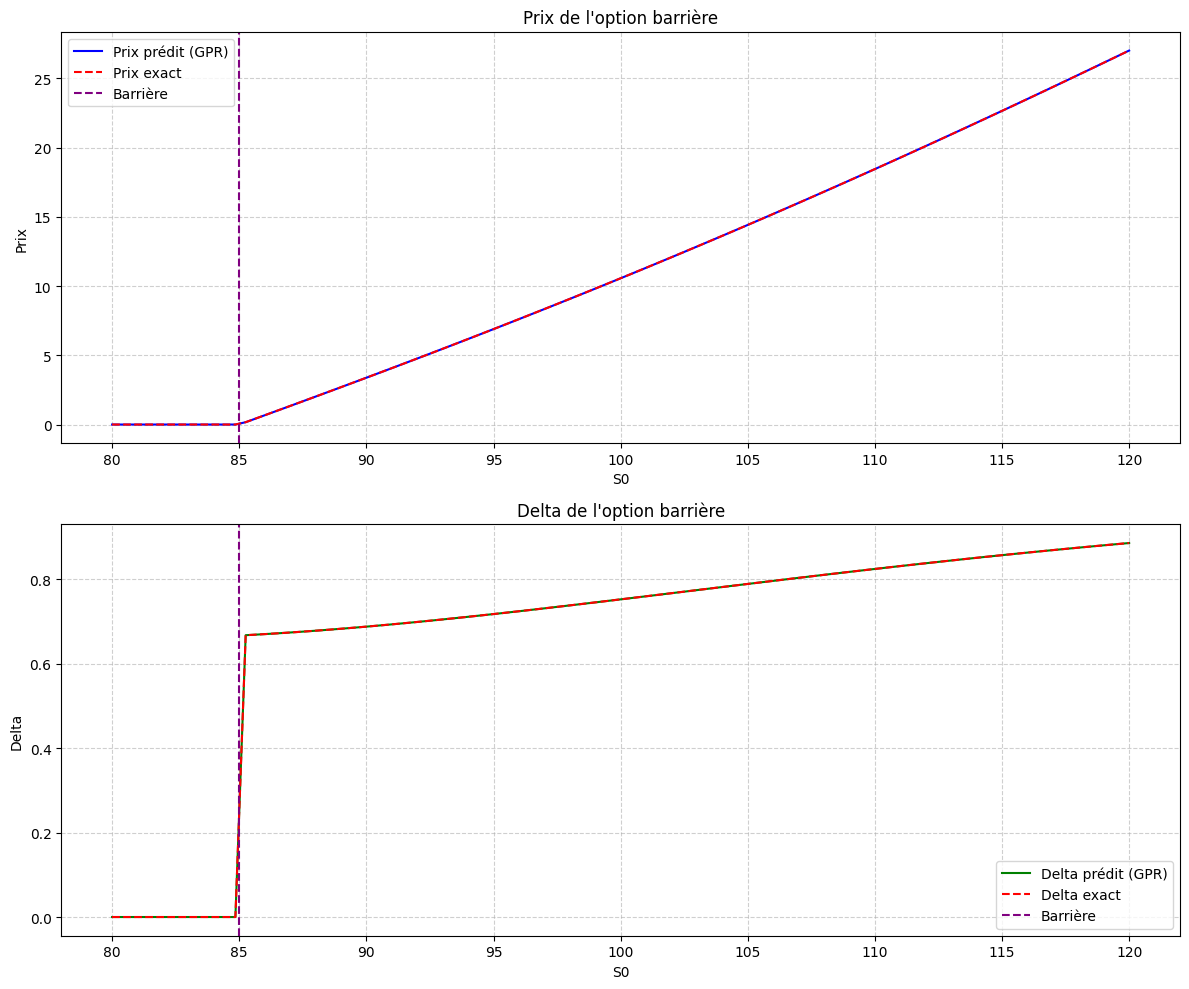

In [22]:
S0_vals = np.linspace(80, 120, 100)
prix_exact = [down_and_out_call_price(s, K, B, r, sigma, T) for s in S0_vals]
delta_exact = [down_and_out_call_delta(s, K, B, r, sigma, T) for s in S0_vals]

# À remplacer par les prédictions GPR si disponibles :
prix_pred = prix_exact  # Placeholder
delta_pred = delta_exact  # Placeholder

# Affichage
plot_price_and_delta(S0_vals, prix_pred, delta_pred, prix_exact=prix_exact, delta_exact=delta_exact, B=B)


## 7. Tableau comparatif des erreurs



/var/folders/vy/_lpj4bm56kqfvhjsl70wykwm0000gn/T/ipykernel_28389/2642081884.py:9: RuntimeWarning: invalid value encountered in sqrt
  std_train = np.sqrt(np.diag(cov_train))


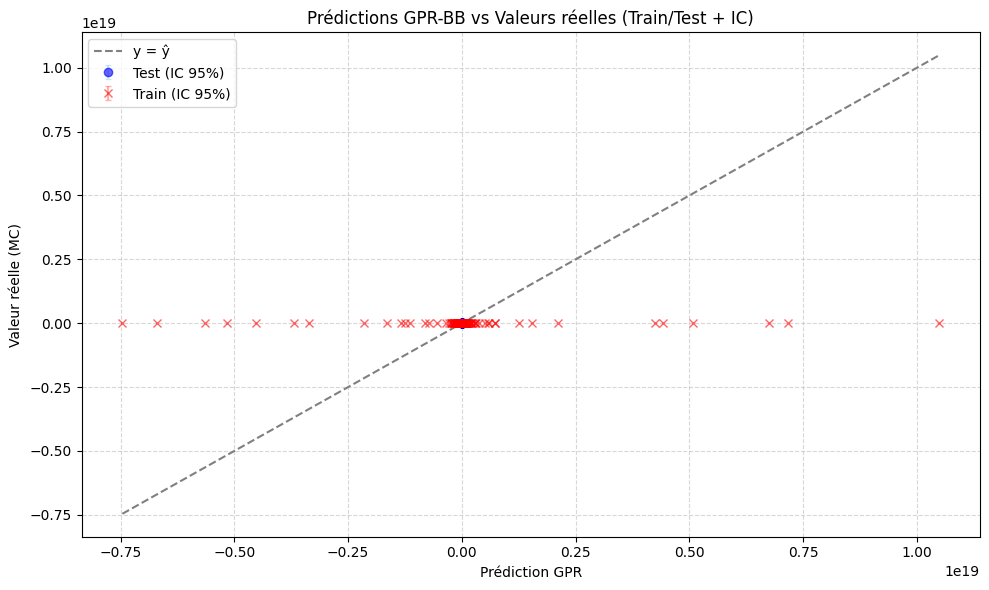

In [24]:
# Prédictions sur test
mu_test, cov_test = gpr_bb.predict(X_test_bb)
std_test = np.sqrt(np.diag(cov_test))
IC_upper_test = mu_test + 1.96 * std_test
IC_lower_test = mu_test - 1.96 * std_test

# Prédictions sur train (juste pour affichage)
mu_train, cov_train = gpr_bb.predict(X_train_bb)
std_train = np.sqrt(np.diag(cov_train))
IC_upper_train = mu_train + 1.96 * std_train
IC_lower_train = mu_train - 1.96 * std_train

# Tracé
plt.figure(figsize=(10, 6))

# Test points avec IC
plt.errorbar(mu_test, y_test_bb, yerr=1.96 * std_test, fmt='o', color='blue', alpha=0.6, ecolor='lightblue', capsize=2, label='Test (IC 95%)')

# Training points avec IC
plt.errorbar(mu_train, y_train_bb, yerr=1.96 * std_train, fmt='x', color='red', alpha=0.6, ecolor='salmon', capsize=2, label='Train (IC 95%)')

# Ligne diagonale de référence
lims = [min(mu_test.min(), mu_train.min()), max(mu_test.max(), mu_train.max())]
plt.plot(lims, lims, '--', color='gray', label='y = ŷ')

# Axes et titre
plt.xlabel("Prédiction GPR")
plt.ylabel("Valeur réelle (MC)")
plt.title("Prédictions GPR-BB vs Valeurs réelles (Train/Test + IC)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
